In [1]:
import matplotlib.pyplot as plt  # Data 可視化
import seaborn as sns  # Data可視化
import pandas as pd  # TableData加工
import numpy as np  # 数値計算の効率化
import random  # 乱数の取り扱い
from sklearn.preprocessing import LabelEncoder  # Category変数の生成
import lightgbm as lgb  # 機械学習Model
from sklearn.model_selection import KFold  # Cross-validation の取り扱い
from sklearn.metrics import mean_squared_error  # 平均二乗誤差の取り扱い
import warnings

plt.style.use("ggplot")  # 描画の Design型
np.random.seed(1234)  # 乱数の種を指定
random.seed(1234)  # 乱数の種を指定
warnings.filterwarnings("ignore")  # 注意書きを非表示に

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

# Benchmark を作成する
実行する各処理が精度向上にどれだけ効果があるかを検証するために、「何も考えずに最低限Category変数を LabelEncode しただけの Data を LightGBM に入れ時の精度」 を確認しておく。

## LightGBM で予測する
最初に、LightGBM を使用する。
LightGBM は各変数の重要度を出すことができる為、今後の処理の優先順位などを考える指標になる。

In [5]:
# 各変数の型の確認
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [6]:
# MSZoning の各分類ごとの個数を確認する
df_train["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

LightGBM に読み込めるのは int型, float型となるため、文字列の Data を Category変数に変換していく

### 学習Data と Test-data を連結して前処理を行なう
もし学習Data で変換表を作成した場合、Test-data にしか存在しないものがあると、変換できずに Error になってしまうので、学習Data と Test-data を結合し、一括で LabelEncoding で Category変数に変換する。

In [7]:
# 学習Data と Test-data の連結
df_all = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)
df_all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


SalePrice の Data が存在するものが学習Data, 存在しないものが Test-data になる為、予測の際は SalePrice のData の有無で Data を分割する。

In [8]:
# 目的変数である SalePrice の値を取得
df_all["SalePrice"]

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

### Category変数を数値に変換する

In [9]:
# Object型の 変数を取得
categories = df_all.columns[df_all.dtypes == "object"]
categories

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

### 欠損値を数値に変換する
欠損値について NaN 自体に意味がある変数がある為、missing という文字列に変換後、数値に変換する。
また、Category変数であることを明示するため、astype("category")としておく。

In [10]:
# 欠損値を数値に変換する
for category in categories:
    label_encoder = LabelEncoder()
    print(category)

    df_all[category].fillna("missing", inplace=True)
    label_encoder = label_encoder.fit(df_all[category])
    df_all[category] = label_encoder.transform(df_all[category])
    df_all[category] = df_all[category].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [11]:
df_all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


### 再び学習Data と Test-data に戻す
以上の処理で、LightGBM など各種機械学習Model に Data を読み込み込めるようになった為、再び学習Data と Test-data に戻す。

In [12]:
# Data を df_train と df_test に戻す
df_train_le = df_all.loc[~df_all["SalePrice"].isnull()]
df_test_le = df_all.loc[df_all["SalePrice"].isnull()]

## Cross-validation を用いて Model の学習・予測を行なう
学習Data を３分割して、各Data で Model を作成した際の Test-data に対する予測精度の平均を確認してみる。

In [13]:
folds = 3
kf = KFold(n_splits=folds)

Hyper-parameter について、ひとまず回帰分析用の Model である "objective":"regression" のみを設定する

In [14]:
# LightGBM の Hyper-parameter を設定
lgbm_params = {
    "objective": "regression",
    "random_seed": 1234
}

- 目的変数: SalePrice
- 説明変数: 学習Data の全変数から目的変数である「SalePrice」と学習に不要な「ID」を除いたもの

を指定する

In [15]:
# 説明変数、目的変数を指定
train_X = df_train_le.drop(["SalePrice", "Id"], axis=1)
train_Y = df_train_le["SalePrice"]

### 各foldごとに作成した Model ごとの予測値を保存する

In [16]:
models = []  # 各fold ごとに作成した Model を格納
rmses = []  # rmse の計算結果を格納
out_of_fold = np.zeros(len(train_X))  # その Data以外を用いて作成した Model でその Data の目的変数を予測した値

for train_index, val_index in kf.split(train_X):  # 各kf.split()で、train_X を分割した結果の index を得る
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10, )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse, "\n")

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    out_of_fold[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.57807e+09
[20]	valid_0's l2: 7.38516e+08
[30]	valid_0's l2: 5.93255e+08
[40]	valid_0's l2: 5.6061e+08
[50]	valid_0's l2: 5.48225e+08
[60]	valid_0's l2: 5.46182e+08
[70]	valid_0's l2: 5.51735e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08
0.12719558859476132 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 

平均 RMSE を計算する

In [17]:
sum(rmses) / len(rmses)

0.13591644792333177

上記の値から予測精度を改善していく。

### 現状の予測値と実際の値の違いを確認する
- 現状の予測値: `out_of_fold`
- 実際の値: `train_Y`

となるので、現状の予測値と実際の値の違いを見ておく。

In [18]:
# 現状の予測値と実際の値の違いを可視化
df_actual_pred = pd.DataFrame({
    "actual": train_Y,
    "pred": out_of_fold
})

<AxesSubplot: >

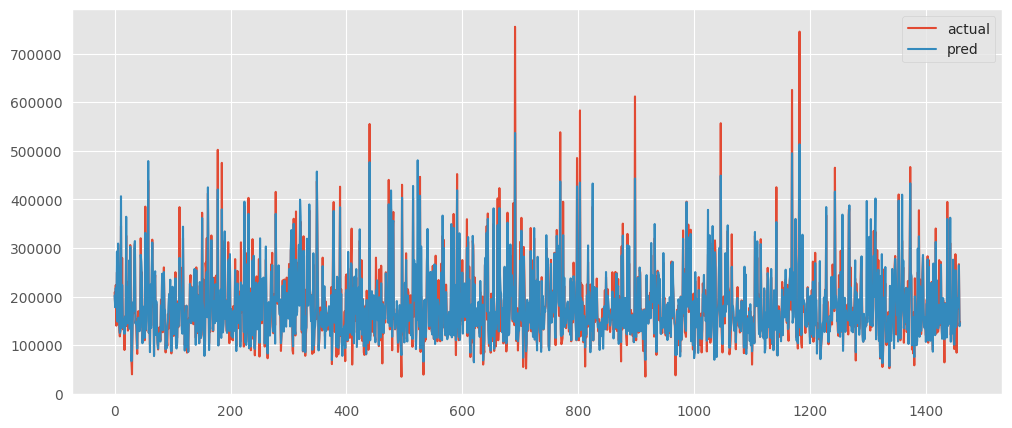

In [19]:
df_actual_pred.plot(figsize=(12, 5))
# Id ごとの横比較をしたいわけではないので線Graph を利用するのは違和感を感じるかもしれないが Simple な Code で各Id ごとの予測値と実際の値の差を確認。

大きな傾向としては追えているが、実際の値が大きくなる時に十分に大きな値として予測できていない様子。
- このような値をうまく捉えるためにどのような工夫をすべきか。
- 通常の傾向とは異なる「外れ値」として学習から除外するか。

などを検討していく。

### 各変数の重要度を確認する
そのままでは変数の数が多いので、変数の数を制限して表示する。

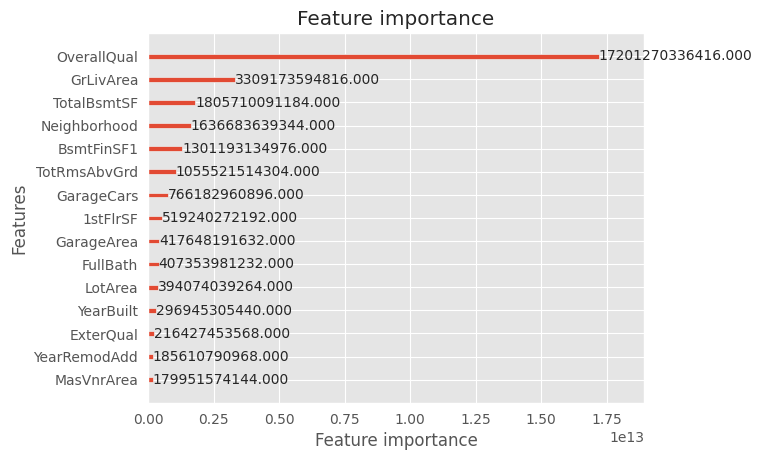

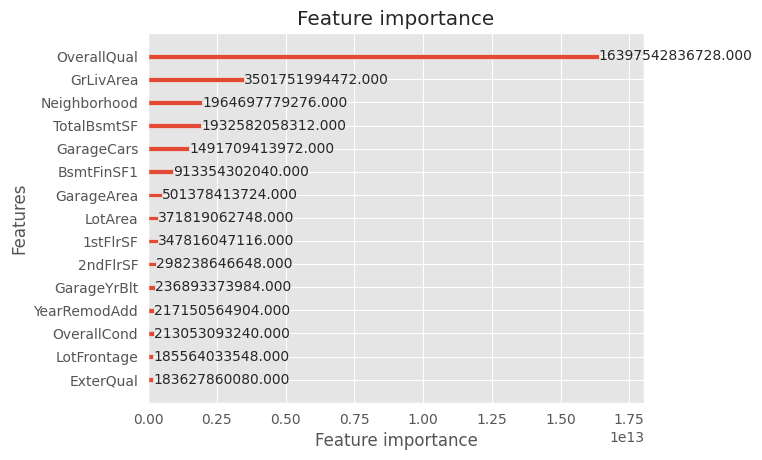

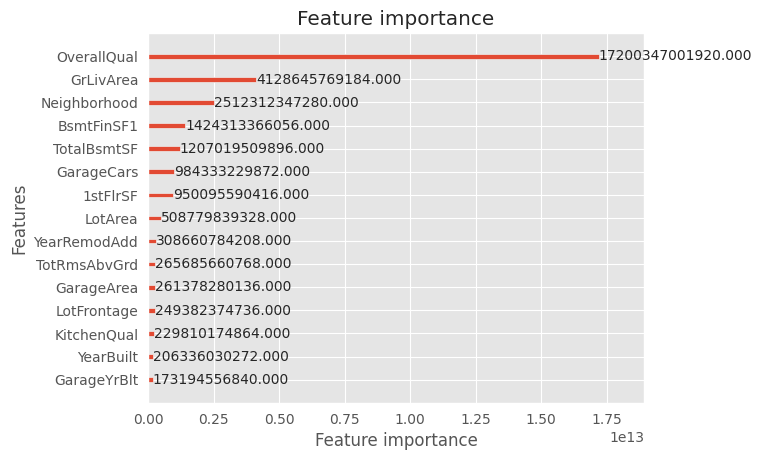

In [20]:
# 変数の数を制限して各変数の重要度を表示
for model in models:
    lgb.plot_importance(model, importance_type="gain", max_num_features=15)

#### OverallQual（全体の質感などを含めた Quality）:
数値が入っているが、10 が Very Excellent, 1 が Very poor となっている Category変数。Category変数として明示することで、より内部的に適切に処理してくれ、必要に応じて前処理を行なう必要。

#### GrLivArea（住居部分の廣さ）:
外れ値などが含まれていないか確認が必要。

#### その他:
- TotalBsmtSF（地下の廣さ）
- GarageCars（Garage に入る車の数）
- GarageArea（Garage の広さ）
- GarageYrBlt（Garage の年数）

などが続く。重要度の高いものは優先的に確認していく。

# 目的変数の前処理: 目的変数の分布を確認する

In [21]:
df_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot: ylabel='Frequency'>

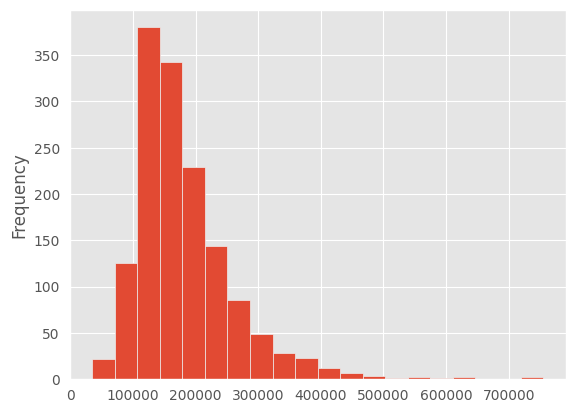

In [22]:
df_train["SalePrice"].plot.hist(bins=20)

左側に最頻値が寄っている Poison分布に近い分布となっている。

### 目的変数を数値化する
- 一般的に機械学習や統計的な処理の多くは Data が正規分布であることを想定している。
- 感覚的には、平均値・中央値付近に多くの Data が存在していることから、そこの差異が重要で詳細を確認把握できるようにしていきたい。
- Competition の評価指標が RMSE と実際の値の対数と予測値の対数になる。

以上から、目的変数を対数化してみる

In [23]:
np.log(df_train["SalePrice"])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<AxesSubplot: ylabel='Frequency'>

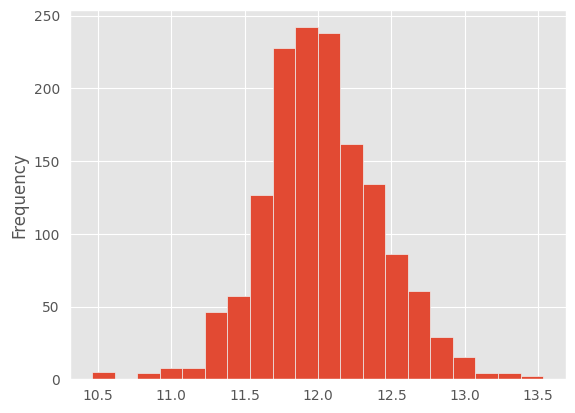

In [24]:
np.log(df_train["SalePrice"]).plot.hist(bins=20)

最頻値を中心として左右対称に近い分布となった。
以降は、この対数をとった目的変数を用いて Model を作成していく。

### 目的変数をの対数化による予測精度の向上を確認する

In [25]:
df_train_le["SalePrice_log"] = np.log(df_train_le["SalePrice"])

In [26]:
train_X = df_train_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = df_train_le["SalePrice_log"]

In [27]:
models = []
rmses_1 = []
out_of_fold = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10, )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses_1.append(tmp_rmse)
    out_of_fold[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0219638
[30]	valid_0's l2: 0.0178863
[40]	valid_0's l2: 0.0168272
[50]	valid_0's l2: 0.0165421
[60]	valid_0's l2: 0.0164067
[70]	valid_0's l2: 0.0163235
[80]	valid_0's l2: 0.0162611
[90]	valid_0's l2: 0.0162673
[100]	valid_0's l2: 0.0163207
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 0.0162538
0.12749050377720011
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGB

In [29]:
print(f"目的変数を事前に対数化しない: {sum(rmses) / len(rmses)}")
print(f"目的変数を事前に対数化する: {sum(rmses_1) / len(rmses_1)}")

目的変数を事前に対数化しない: 0.13591644792333177
目的変数を事前に対数化する: 0.13274830975285581


事前に対数化することで精度が向上した。

# 説明変数の前処理: 欠損値を確認する
本Data では欠損は入力Miss ではなく、意味があることに注意する。

In [51]:
# df_all の作成
df_all = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [52]:
categories = df_all.columns[df_all.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [53]:
# 欠損値の数が上位40の変数を確認
df_all.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
BsmtFinSF1          1
BsmtFinSF2          1
SaleType            1
Electrical          1
GarageCars          1
TotalBsmtSF         1
GarageArea          1
Exterior2nd         1
Exterior1st         1
KitchenQual         1
BsmtUnfSF           1
Fireplaces          0
TotRmsAbvGrd        0
SaleCondition       0
OpenPorchSF         0
YrSold              0
dtype: int64

- SalePrice は df_test に含まれていないため欠損値があるのは当然。
- PoolQC, MiscFeature, Alley, Fence などは非常に多くの多くの欠損がある。
- 重要度の高い変数として出てきた Garage系の変数もいくつか欠損している。

### 欠損値の多い高級住宅設備に関する変数をまとめる
90%以上の Data が欠損している
- PoolQC
- MiscFeature
- Alley

といった高級住宅に関する設備項目は、値がないものがほとんどなので、まとめて高級な設備の有無に変換した上で、もとの Data は削除することにする。

In [54]:
# PoolQC の各分類ごとの個数
df_all["PoolQC"].value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

値があるものは 10個しかない。

In [55]:
# 値があるものを1, 値がないものを 0 に変換
df_all.loc[~df_all["PoolQC"].isnull(), "PoolQC"] = 1
df_all.loc[df_all["PoolQC"].isnull(), "PoolQC"] = 0

# Data の確認
df_all["PoolQC"].value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

In [56]:
df_all["MiscFeature"].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [57]:
df_all["Alley"].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [58]:
# MiscFeature も 0 と 1 に変換する
df_all.loc[~df_all["MiscFeature"].isnull(), "MiscFeature"] = 1
df_all.loc[df_all["MiscFeature"].isnull(), "MiscFeature"] = 0

# Data の確認
df_all["MiscFeature"].value_counts()

0    2814
1     105
Name: MiscFeature, dtype: int64

In [60]:
# Alley も 0 と 1 に変換する
df_all.loc[~df_all["Alley"].isnull(), "Alley"] = 1
df_all.loc[df_all["Alley"].isnull(), "Alley"] = 0

# Data の確認
df_all["Alley"].value_counts()

0    2721
1     198
Name: Alley, dtype: int64

In [62]:
# 0 か 1 の値に変換した各変数を足しあわせて、hasHighFacility（高級住宅設備の数）という特徴量を作成
df_all["hasHighFacility"] = df_all["PoolQC"] + df_all["MiscFeature"] + df_all["Alley"]
df_all["hasHighFacility"]

0       0
1       0
2       0
3       0
4       0
       ..
2914    0
2915    0
2916    0
2917    1
2918    0
Name: hasHighFacility, Length: 2919, dtype: object

In [67]:
# hasHighFacility（高級住宅設備の数）の Data型を int に変換
df_all["hasHighFacility"] = df_all["hasHighFacility"].astype(int)
df_all["hasHighFacility"]

0       0
1       0
2       0
3       0
4       0
       ..
2914    0
2915    0
2916    0
2917    1
2918    0
Name: hasHighFacility, Length: 2919, dtype: int64

In [68]:
# hasHighFacility ごとの家の数を確認
df_all["hasHighFacility"].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

- 多くの住宅は、高級住宅の設備の数は 0
- 少数の家が 1つ
- ごく少数の家が 2つ

の設備を持つ。

In [69]:
# hasHighFacility に変数をまとめたので, PoolQC, MiscFeature, Alley を削除
df_all.drop(["PoolQC", "MiscFeature", "Alley"], axis=1, inplace=True)